<a href="https://colab.research.google.com/github/teruyo14/Classification-of-CIFAR10-with-Major-CNNs-and-Visualization-with-t-SNE/blob/main/Classification_of_CIFAR10_with_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Papers: ImageNet Classification with Deep Convolutional Neural Networks  
https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import copy

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

100%|██████████| 170498071/170498071 [00:12<00:00, 13165084.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True)
        )

        self.classifier2 = nn.Linear(4096, num_classes)

    def forward(self, x, return_embed=False):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = self.classifier2(x)
        if return_embed:
            return x
        return x

    def get_device(self):
        return self.classifier2.weight.device

    def copy(self):
        return copy.deepcopy(self)

In [ ]:
model = AlexNet(10)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00008, weight_decay=5e-4)

In [ ]:
def plot_t_sne(data_loader, model,num_samples):
    model.eval()

    # Formatting data for t-SNE
    x = []
    y = []
    for imgs, labels in data_loader:
        with torch.no_grad():
            imgs = imgs.to(model.get_device())

            # Extracting features
            embeddings = model(imgs, return_embed=True)

            x.append(embeddings.to('cpu'))
            y.append(labels.clone())

    x = torch.cat(x)
    y = torch.cat(y)

    # To Numpy Array
    x = x.numpy()
    y = y.numpy()

    # Extract a specified number of samples
    x = x[:num_samples]
    y = y[:num_samples]

    # Apply t-SNE
    t_sne = TSNE(n_components=2, random_state=0)
    x_reduced = t_sne.fit_transform(x)

    # Set color and marker for each label
    cmap = plt.get_cmap("tab10")
    markers = ['4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D']

    # Plot data
    plt.figure(figsize=(20, 15))
    for i, cls in enumerate(data_loader.dataset.classes):
        plt.scatter(x_reduced[y == i, 0], x_reduced[y == i, 1],
                    c=[cmap(i / len(data_loader.dataset.classes))],
                    marker=markers[i], s=500, alpha=0.6, label=cls)
    plt.axis('off')

    plt.legend(bbox_to_anchor=(1, 1), fontsize=24, framealpha=0)
    plt.title("Model:AlexNet", fontsize = 70, y = -0.1)
    plt.show()

epoch: 1, loss: 1.6279333316204416, acc: 0.3897152841091156,      val loss: 1.304504365014573, val acc: 0.5188698172569275
epoch: 2, loss: 1.2595064617164304, acc: 0.5405470132827759,      val loss: 1.1375590159108464, val acc: 0.594648540019989
epoch: 3, loss: 1.0900643485445132, acc: 0.6077055335044861,      val loss: 0.9998254545580465, val acc: 0.6449680328369141
epoch: 4, loss: 0.9708306503578096, acc: 0.65537029504776,      val loss: 0.8765957964875828, val acc: 0.6859025359153748
epoch: 5, loss: 0.8758245114325257, acc: 0.6896393299102783,      val loss: 0.8077131899210591, val acc: 0.7175518870353699
epoch: 6, loss: 0.8013669284810184, acc: 0.7190499305725098,      val loss: 0.7757340992411105, val acc: 0.7316293716430664
epoch: 7, loss: 0.749582084149637, acc: 0.7376639246940613,      val loss: 0.7160478178114175, val acc: 0.7475039958953857
epoch: 8, loss: 0.6976186851431602, acc: 0.7553982734680176,      val loss: 0.6748935026101792, val acc: 0.7623801827430725
epoch: 9, los

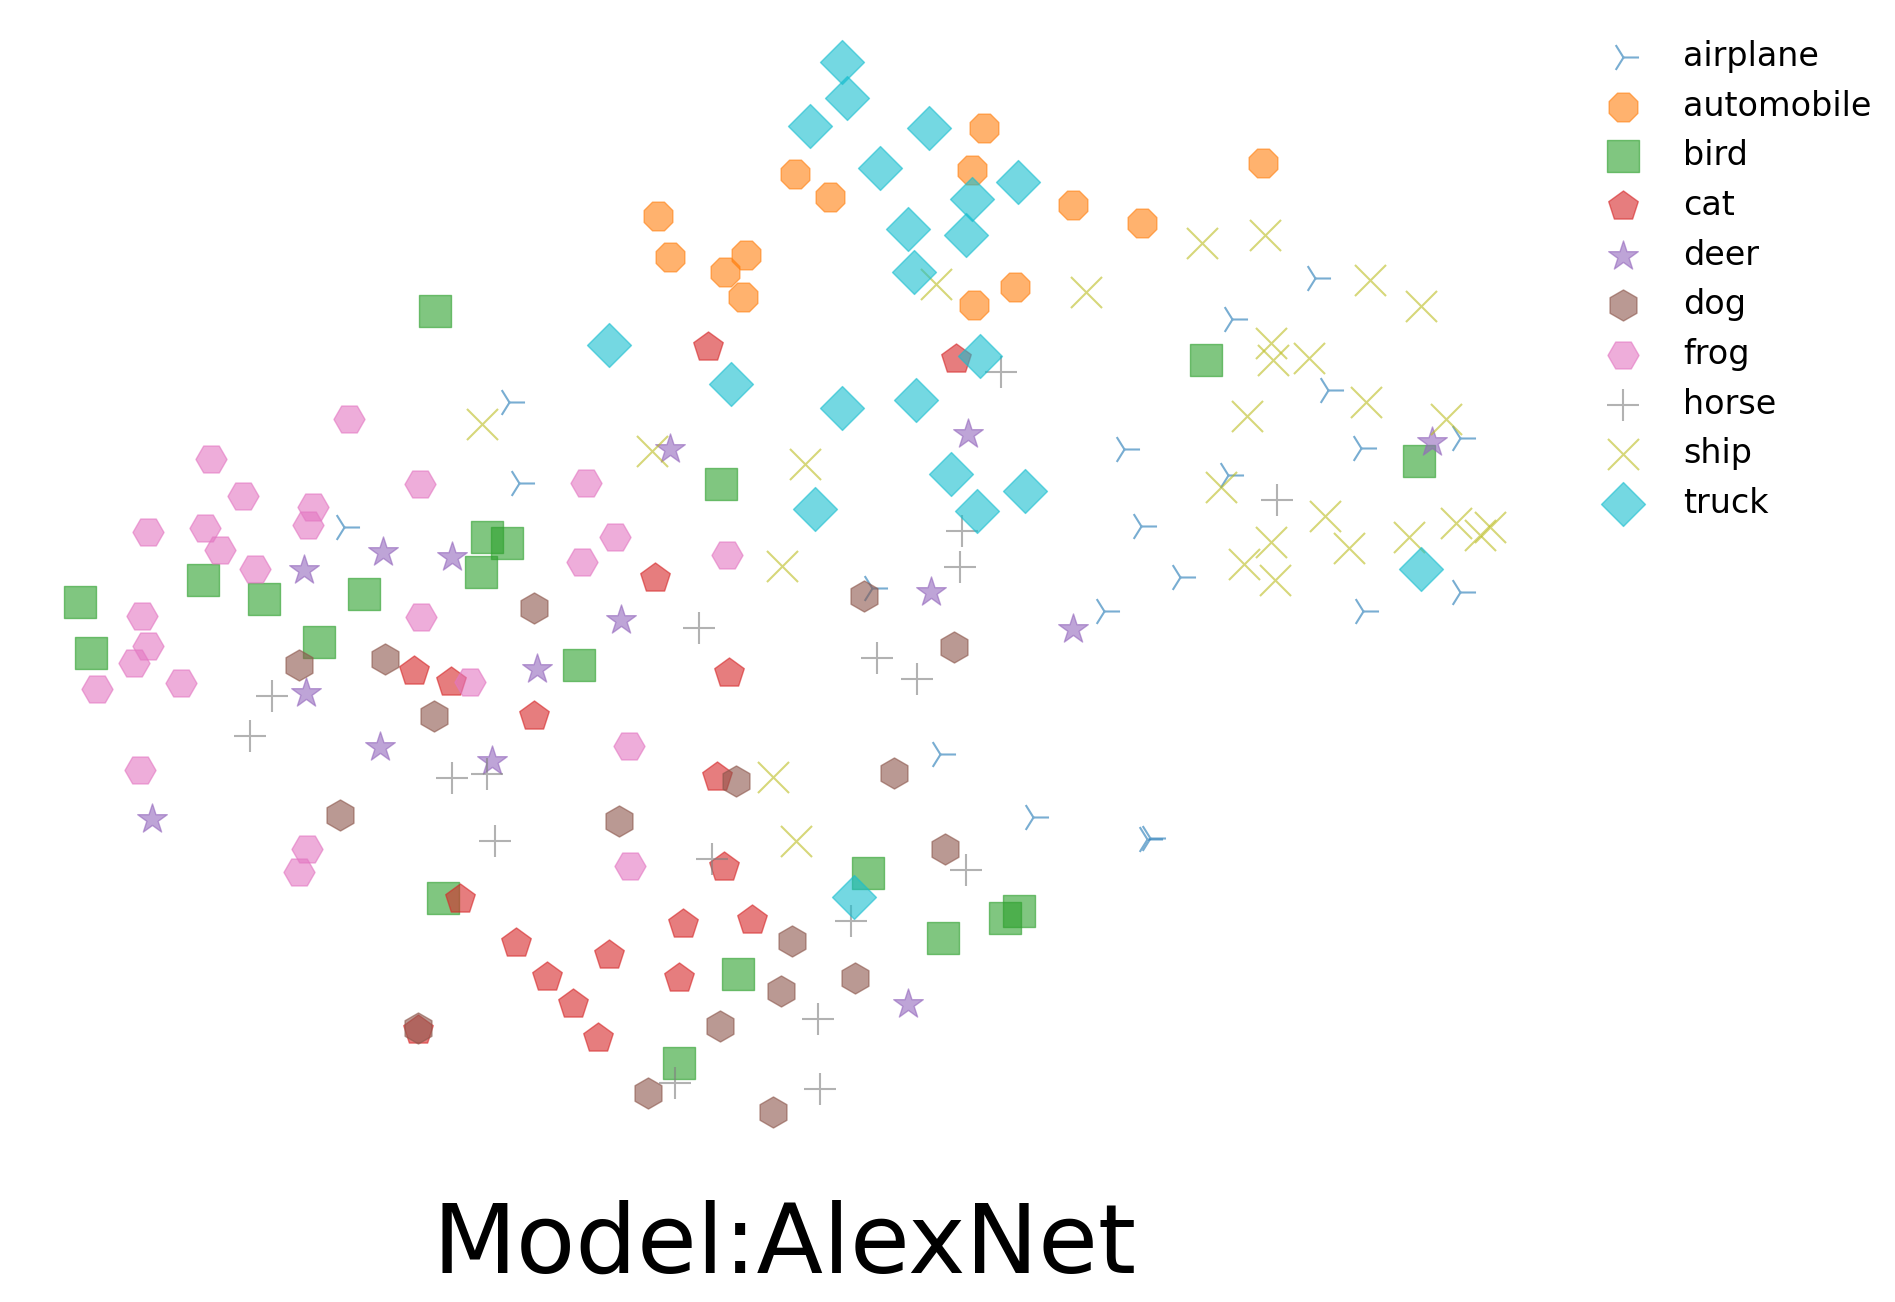

In [ ]:
num_epochs = 20
num_samples = 200
losses = []
accs = []
val_losses = []
val_accs = []
val_acc_best = 0.0
model_best = None
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc.item())
    #
    # validation loop
    #
    model.eval()
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc.item())
    if val_running_acc > val_acc_best:
            val_acc_best = val_loss
            model_best = model.copy()
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch+1, running_loss, running_acc, val_running_loss, val_running_acc))

# Plot distribution of features using t-SNE
plot_t_sne(validation_dataloader, model_best, num_samples)

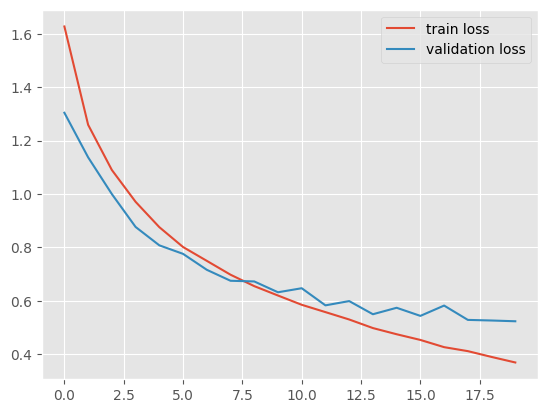

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

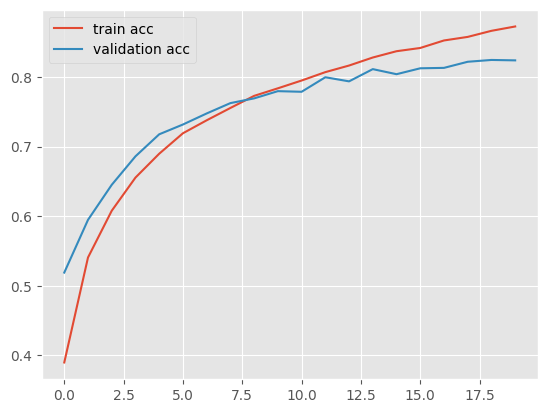

In [ ]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.legend()